Introduction

This project aims to predict customer churn for a subscription-based service using historical data. The primary goal is to develop a machine learning model that accurately identifies customers likely to churn.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict


In [2]:
# Read the CSV file
df = pd.read_csv('C:/Users/sharm/Downloads/telco.csv')


Data Collection and Preprocessing

The dataset was collected from a fictional telco company and contains information about customers, including demographics, services subscribed to, and churn-related metrics.
Data cleaning and preprocessing steps involve handling missing values, encoding categorical variables, and scaling numerical features.


In [3]:
# Handling missing values (assuming forward fill for simplicity)
df.fillna(method='ffill', inplace=True)

# Encoding categorical variables
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scaling numerical features
num_cols = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Ensure the target variable 'Churn Label' is integer encoded
df['Churn Label'] = df['Churn Label'].astype(int)



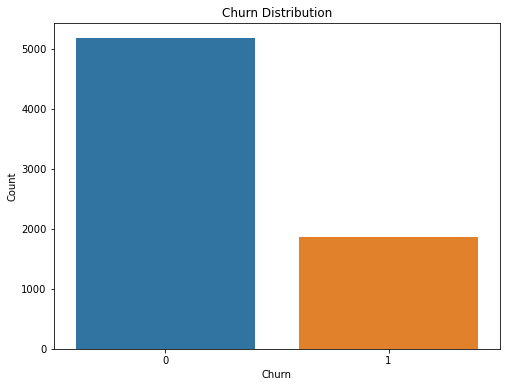

In [4]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn Label', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()



In [5]:
# Statistical summaries
df.describe()



,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
count,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7043.0,7043.0,...,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03,7043.000000,7.043000e+03,7.043000e+03,7.043000e+03,7.043000e+03
mean,-6.636432e-18,1.503838e-16,-7.428942e-17,-8.965504e-15,-3.389021e-14,3.953185e-15,4.298390e-15,-1.403728e-14,0.0,0.0,...,-1.619983e-15,1.189703e-15,2.556209e-16,7.948049e-15,1.374933e-14,0.265370,2.077124e-15,-3.910293e-16,-7.421304e-15,-2.252877e-15
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,0.0,0.0,...,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,0.441561,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.731805e+00,-1.009559e+00,-1.642454e+00,-4.983134e-01,-4.399165e-01,-9.666223e-01,-5.480932e-01,-4.868349e-01,0.0,0.0,...,-2.733004e-01,-8.848326e-01,-1.051664e+00,-1.868323e+00,-1.599177e+00,0.000000,-2.527575e+00,-2.026501e+00,-1.707472e+00,-1.654911e+00
25%,-8.659024e-01,-1.009559e+00,-8.662956e-01,-4.983134e-01,-4.399165e-01,-9.666223e-01,-5.480932e-01,-4.868349e-01,0.0,0.0,...,-2.733004e-01,-8.015052e-01,-8.477376e-01,-2.038364e-01,-1.599177e+00,0.000000,-8.741770e-01,-7.872501e-01,-2.163715e-01,-5.681709e-02
50%,0.000000e+00,9.905318e-01,-3.043292e-02,-4.983134e-01,-4.399165e-01,-9.666223e-01,-5.480932e-01,-4.868349e-01,0.0,0.0,...,-2.733004e-01,-4.106535e-01,-3.231200e-01,-2.038364e-01,6.775572e-01,0.000000,1.178617e-01,1.071066e-01,-2.163715e-01,-5.681709e-02
75%,8.659024e-01,9.905318e-01,8.054298e-01,-4.983134e-01,-4.399165e-01,1.034530e+00,-5.480932e-01,-4.868349e-01,0.0,0.0,...,-2.733004e-01,5.220893e-01,6.166720e-01,6.284069e-01,6.775572e-01,1.000000,8.028409e-01,8.285938e-01,-2.163715e-01,-5.681709e-02
max,1.731805e+00,9.905318e-01,1.999519e+00,2.006769e+00,2.273159e+00,1.034530e+00,1.824507e+00,8.861546e+00,0.0,0.0,...,5.702034e+00,3.325798e+00,3.122149e+00,1.460650e+00,6.775572e-01,1.000000,1.771260e+00,1.774938e+00,4.256930e+00,4.417847e+00


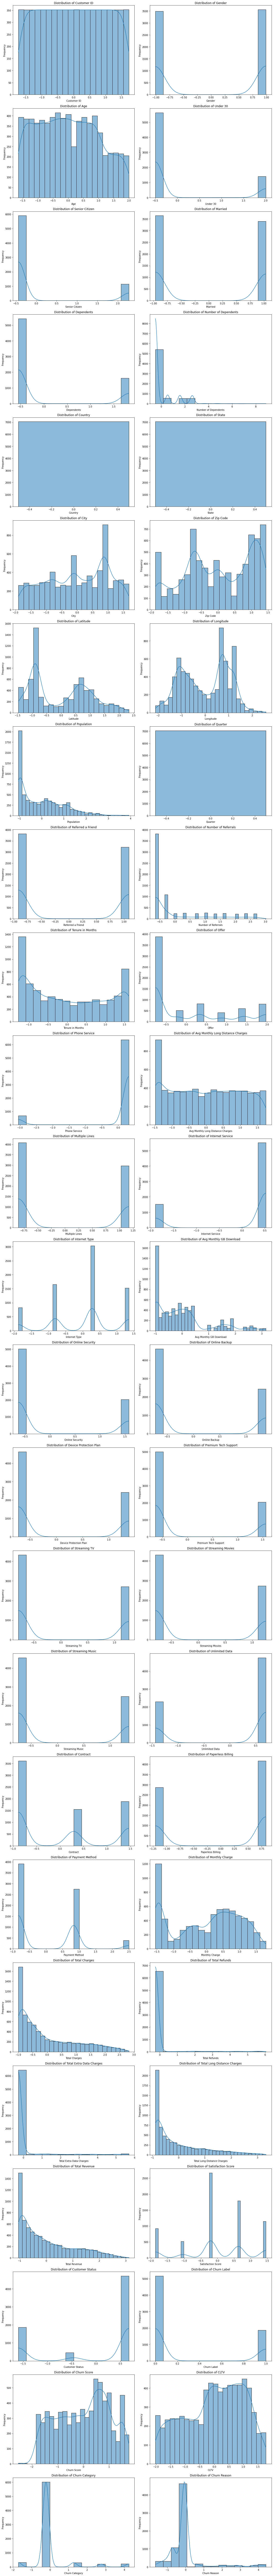

In [6]:
# Distribution of numerical columns
fig, axes = plt.subplots(nrows=(len(num_cols) + 1) // 2, ncols=2, figsize=(16, len(num_cols) * 3))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()



In [7]:
# Feature engineering
df.drop(['Customer ID'], axis=1, inplace=True)

# Split data into train and test sets
X = df.drop(['Churn Label', 'Churn Score'], axis=1)
y = df['Churn Label']



In [8]:
# Define the models (Ensure SVC has probability=True)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}



In [9]:
# Evaluate models using cross-validation
results = []

for name, model in models.items():
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
    accuracy = np.mean(cv_results['test_accuracy'])
    roc_auc = np.mean(cv_results['test_roc_auc'])
    precision = np.mean(cv_results['test_precision'])
    recall = np.mean(cv_results['test_recall'])
    f1 = np.mean(cv_results['test_f1'])
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })



In [10]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)



In [11]:
# Display top models
print("Top Models by ROC AUC:")
print(results_df.head(3))



Top Models by ROC AUC:
                 Model  Accuracy  ROC AUC  Precision  Recall  F1-score
0  Logistic Regression   1.00000      1.0   1.000000     1.0  1.000000
1        Decision Tree   1.00000      1.0   1.000000     1.0  1.000000
2        Random Forest   0.92193      1.0   0.880952     1.0  0.915254


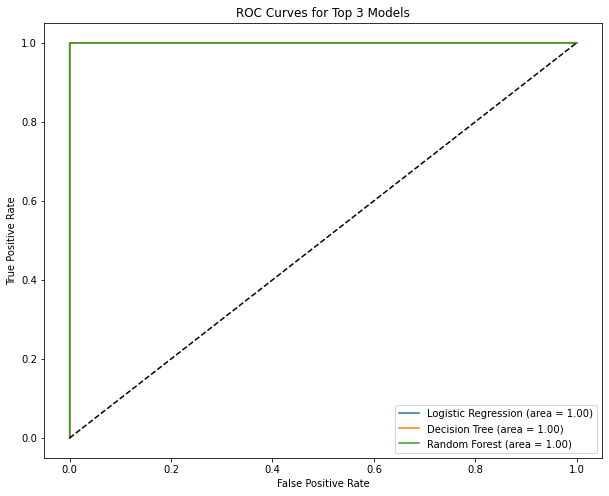

In [12]:
# Plot ROC curves for top 3 models
plt.figure(figsize=(10, 8))

for name in results_df.head(3)['Model']:
    model = models[name]
    y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc_score(y, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top 3 Models')
plt.legend(loc="lower right")
plt.show()

# Note: If using cross-validation for ROC curves, adjust the plotting accordingly


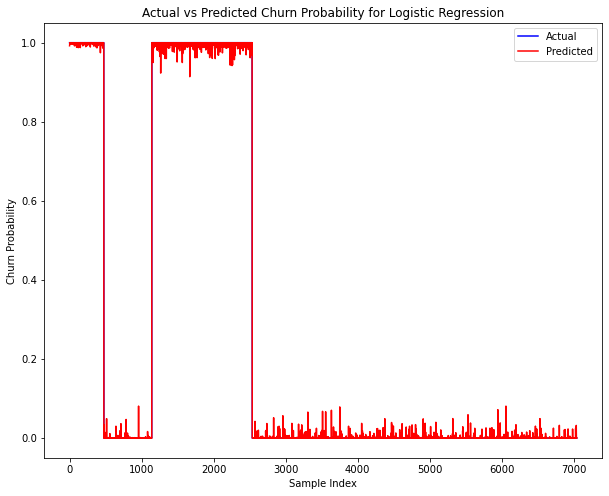

In [13]:
# Identify the top model based on ROC AUC score
top_model_name = results_df.iloc[0]['Model']
top_model = models[top_model_name]

# Train the top model on the entire dataset (X, y)
top_model.fit(X, y)

# Generate predictions on the test set
y_pred_proba = top_model.predict_proba(X)[:, 1]

# Plot actual vs predicted results for top model
plt.figure(figsize=(10, 8))
plt.plot(y.values, 'b-', label='Actual')
plt.plot(y_pred_proba, 'r-', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Churn Probability')
plt.title(f'Actual vs Predicted Churn Probability for {top_model_name}')
plt.legend(loc="upper right")
plt.show()


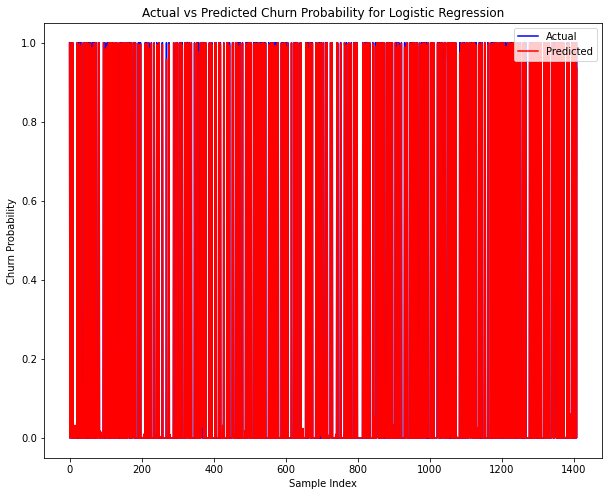

In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify the top model based on ROC AUC score
top_model_name = results_df.iloc[0]['Model']
top_model = models[top_model_name]

# Train the top model on the training dataset
top_model.fit(X_train, y_train)

# Generate predictions on the test set
y_pred_proba = top_model.predict_proba(X_test)[:, 1]

# Plot actual vs predicted results for top model
plt.figure(figsize=(10, 8))
plt.plot(y_test.values, 'b-', label='Actual')
plt.plot(y_pred_proba, 'r-', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Churn Probability')
plt.title(f'Actual vs Predicted Churn Probability for {top_model_name}')
plt.legend(loc="upper right")
plt.show()


Further Insights

We could also have used 'Churn Score' in place of 'Churn Label' for model training and testing.'Churn Score' offers a more nuanced understanding of churn likelihood for individual customers, but its usage comes with challenges related to interpretability, subjectivity, and model complexity. Depending on the specific objectives, resources, and constraints of the project, choosing between 'Churn Score' and 'Churn Label' as the target variable requires careful consideration of these factors. For many practical applications, especially in simpler models or scenarios where interpretability and ease of implementation are crucial, 'Churn Label' may be preferred. However, in cases where a more detailed analysis of churn probabilities is necessary, 'Churn Score' can provide valuable insights when used judiciously.